# Diabetes Hospitalizations

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 50)

### Location of Dataset:

https://data.world/uci/diabetes-130-us-hospitals-for-years-1999-2008

### Article for which data was collected originally:
https://www.hindawi.com/journals/bmri/2014/781670/

## Import Data and Cleaning

In [2]:
df = pd.read_csv('https://query.data.world/s/fzhdybgova7pqh6amwfzrnhumdc26t')

Weight, Payer Code, and Medical Specialty were missing >50% of values.

In [3]:
df.drop(['encounter_id','patient_nbr','weight', 'payer_code', 'medical_specialty'], axis=1, inplace=True)

Changed target variable to 0-2 for classes (No readmit, less than 30 days, more than 30 days).

In [4]:
df.readmitted.replace({'NO': 0, '<30': 1, '>30': 2}, inplace=True)

Parsing the ICD-9 medical billing codes, in order to grab just 250.xx coding diabetes.

In [5]:
df = df[pd.to_numeric(df['diag_1'], errors='coerce').notnull()] # Select non-null values after changing values to
df = df[pd.to_numeric(df['diag_2'], errors='coerce').notnull()] # numeric (removing V27/V57 entries and ?)
df = df[pd.to_numeric(df['diag_3'], errors='coerce').notnull()] #

df.diag_1 = df.diag_1.astype('float64') # Can now recast from Object to Float64 dtypes (want float to preserve
df.diag_2 = df.diag_2.astype('float64') # ICD-9 decimals as part of the billing code)
df.diag_3 = df.diag_3.astype('float64') #

In [6]:
df

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
1,Caucasian,Female,[10-20),1,1,7,3,59,0,18,0,0,0,276.00,250.01,255.0,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,2
3,Caucasian,Male,[30-40),1,1,7,2,44,1,16,0,0,0,8.00,250.43,403.0,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,0
4,Caucasian,Male,[40-50),1,1,7,1,51,0,8,0,0,0,197.00,157.00,250.0,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,0
5,Caucasian,Male,[50-60),2,1,2,3,31,6,16,0,0,0,414.00,411.00,250.0,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,2
7,Caucasian,Male,[70-80),1,1,7,5,73,0,12,0,0,0,428.00,492.00,250.0,8,None,None,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,AfricanAmerican,Male,[70-80),1,3,7,3,51,0,16,0,0,0,250.13,291.00,458.0,9,None,>8,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,2
101762,AfricanAmerican,Female,[80-90),1,4,5,5,33,3,18,0,0,1,560.00,276.00,787.0,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,0
101763,Caucasian,Male,[70-80),1,1,7,1,53,0,9,1,0,0,38.00,590.00,296.0,13,None,None,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,0
101764,Caucasian,Female,[80-90),2,3,7,10,45,2,21,0,0,1,996.00,285.00,998.0,9,None,None,No,No,No,No,No,No,Steady,No,No,Steady,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,0


## EDA

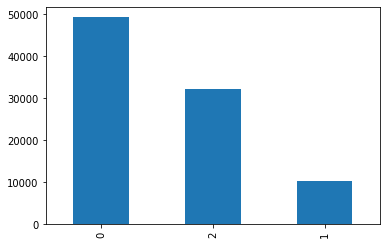

In [7]:
df.readmitted.value_counts().plot(kind='bar')

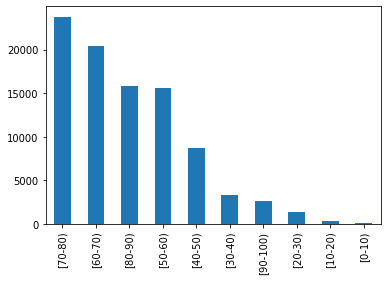

In [8]:
df.age.value_counts().plot(kind='bar')

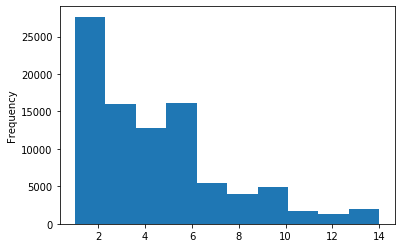

In [9]:
df.time_in_hospital.plot(kind='hist')